<a href="https://colab.research.google.com/github/venkateshblks/CryptoPredictor/blob/main/Notebook/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
!pip install yfinance --quiet

In [138]:
!pip install tensorflow --quiet

In [184]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [140]:
df = yf.download('Btc-usd', period='3mo', interval='1h')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-07-06 06:00:00+00:00,56369.703125,56572.789062,56369.703125,56442.574219,56442.574219,0
2024-07-06 07:00:00+00:00,56429.238281,56661.617188,56429.238281,56589.136719,56589.136719,0
2024-07-06 08:00:00+00:00,56590.437500,56655.253906,56526.289062,56561.667969,56561.667969,0
2024-07-06 09:00:00+00:00,56547.710938,56723.992188,56463.414062,56723.992188,56723.992188,0
2024-07-06 10:00:00+00:00,56756.511719,56845.019531,56668.460938,56793.500000,56793.500000,0


In [141]:
df.shape

(2209, 6)

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2209 entries, 2024-07-06 06:00:00+00:00 to 2024-10-06 06:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2209 non-null   float64
 1   High       2209 non-null   float64
 2   Low        2209 non-null   float64
 3   Close      2209 non-null   float64
 4   Adj Close  2209 non-null   float64
 5   Volume     2209 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 120.8 KB


In [143]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2209.000000,2209.000000,2209.000000,2209.000000,2209.000000,2.209000e+03
mean,61112.990470,61311.166731,60909.955785,61116.245008,61116.245008,3.286273e+08
std,3646.015839,3623.975827,3668.903252,3645.142932,3645.142932,7.099998e+08
min,49813.367188,51525.679688,49578.886719,49842.523438,49842.523438,0.000000e+00
25%,58347.183594,58537.316406,58114.468750,58347.781250,58347.781250,0.000000e+00
50%,60667.648438,60835.121094,60447.824219,60666.015625,60666.015625,0.000000e+00
75%,63938.707031,64091.183594,63775.773438,63955.437500,63955.437500,3.874652e+08
max,69799.054688,69973.351562,69605.000000,69799.414062,69799.414062,9.882083e+09


In [144]:
df.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [145]:
df.index.dtype

datetime64[ns, UTC]

# Data Visualization

In [146]:
k=go.Figure(data=[go.Candlestick(x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlestick'
)])
k.update_layout( title='3 Months Historical Prices',xaxis_title='Date',yaxis_title='Price')

In [147]:
k=go.Figure(data=[go.Scatter(x=df.index,
    y=df['Close'],
    mode='lines+markers',
    name='Close Price'
)])
k.update_layout(title='Close Price Over Time',xaxis_title='Date', yaxis_title='Close Price')


In [148]:
df.describe().Close

,Close
count,2209.000000
mean,61116.245008
std,3645.142932
min,49842.523438
25%,58347.781250
50%,60666.015625
75%,63955.437500
max,69799.414062


In [149]:
k=go.Figure(data=[go.Scatter(x=df.tail(120).index,
    y=df.tail(120)['Close'],
    mode='lines+markers',
    name='Close Price'
)])
k.update_layout(title='5 days Close Prices',xaxis_title='Date',yaxis_title='Price')

In [150]:
k=go.Figure(data=[go.Bar(
    x=df.index,
    y=df['Volume'],
    name='Volume',
    marker_color='blue'
)])
k.update_layout(title='Volume Over Time',xaxis_title='Date',yaxis_title='Volume')


In [151]:
df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.997900,0.997448,0.995712,0.995712,-0.079902
High,0.997900,1.000000,0.996549,0.998060,0.998060,-0.056955
Low,0.997448,0.996549,1.000000,0.997765,0.997765,-0.112894
Close,0.995712,0.998060,0.997765,1.000000,1.000000,-0.080818
Adj Close,0.995712,0.998060,0.997765,1.000000,1.000000,-0.080818
Volume,-0.079902,-0.056955,-0.112894,-0.080818,-0.080818,1.000000


# Feature Engineering

In [152]:
df=df.drop(['Adj Close', 'Volume'], axis=1)

In [153]:
df.index = df.index + pd.Timedelta(hours=5, minutes=30)
df.head(3)   #indian time  +5.30

,Open,High,Low,Close
Datetime,,,,
2024-07-06 11:30:00+00:00,56369.703125,56572.789062,56369.703125,56442.574219
2024-07-06 12:30:00+00:00,56429.238281,56661.617188,56429.238281,56589.136719
2024-07-06 13:30:00+00:00,56590.437500,56655.253906,56526.289062,56561.667969


In [154]:
data=df.copy()

In [155]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

In [156]:
data.head(3)

,Open,High,Low,Close
Datetime,,,,
2024-07-06 11:30:00+00:00,56369.703125,56572.789062,56369.703125,0.330715
2024-07-06 12:30:00+00:00,56429.238281,56661.617188,56429.238281,0.338059
2024-07-06 13:30:00+00:00,56590.437500,56655.253906,56526.289062,0.336683


In [157]:
data.shape

(2209, 4)

In [158]:
df1=data[:-24]

In [159]:
display(data.tail(3))
df1.tail(3) #removed 1 days

,Open,High,Low,Close
Datetime,,,,
2024-10-06 09:30:00+00:00,61886.527344,61944.312500,61837.492188,0.602640
2024-10-06 10:30:00+00:00,61880.636719,61971.812500,61837.691406,0.607023
2024-10-06 11:30:00+00:00,61938.554688,62007.738281,61933.070312,0.609338


,Open,High,Low,Close
Datetime,,,,
2024-10-05 09:30:00+00:00,61878.953125,62009.476562,61831.121094,0.606092
2024-10-05 10:30:00+00:00,61939.910156,62135.238281,61937.808594,0.615925
2024-10-05 11:30:00+00:00,62138.167969,62234.792969,62072.546875,0.620293


In [160]:
dataset=data[:-24]['Close'].values.reshape(-1,1)

In [161]:
time_step = 24  # For one day of hourly data
X, y = [], []
for i in range(len(dataset) - time_step):
    X.append(dataset[i:(i + time_step), 0])
    y.append(dataset[i + time_step, 0])  # The target is the next value after the sequence
X = np.array(X).reshape(len(X), time_step, 1)  # Reshape for LSTM input
y = np.array(y)

In [162]:
data.shape

(2209, 4)

In [163]:
dataset.shape  # 2209-24

(2185, 1)

In [164]:
X.shape  #2161-24

(2161, 24, 1)

In [165]:
y.shape  #training with 2k data to predict next 24 hours

(2161,)

# Model Building

In [166]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [167]:
model.fit(X, y, epochs=30, batch_size=16, verbose=0)

In [168]:
last_sequence = dataset[-time_step:].reshape(1, time_step, 1)
last_sequence.shape

(1, 24, 1)

In [169]:
next_price = model.predict(last_sequence, verbose=0)
next_price.shape

(1, 1)

In [170]:
next_price[0][0]  #== next_price[0,0]

0.61180377

In [171]:
next_predictions = []
last_sequence = dataset[-time_step:].reshape(1, time_step, 1)
for _ in range(24):
    next_price = model.predict(last_sequence, verbose=0)
    next_predictions.append(next_price[0, 0])  # Store the predicted price

    # Update the last sequence for the next prediction
    next_sequence = np.array([[next_price[0, 0]]])
    last_sequence = np.append(last_sequence[:, 1:, :], next_sequence.reshape(1, 1, 1), axis=1)

In [172]:
predicted_prices = scaler.inverse_transform(np.array(next_predictions).reshape(-1, 1)).flatten().tolist()
len(predicted_prices)

24

In [173]:
predicted_prices[:6]

[62052.22265625,
 62097.60546875,
 62116.44140625,
 62122.33203125,
 62121.4765625,
 62116.9140625]

In [179]:
fc_df=pd.DataFrame({'predicted':predicted_prices,'actual':df.tail(24).Close  })
fc_df

,predicted,actual
Datetime,,
2024-10-05 12:30:00+00:00,62052.222656,62091.136719
2024-10-05 13:30:00+00:00,62097.605469,62135.425781
2024-10-05 14:30:00+00:00,62116.441406,62269.382812
2024-10-05 15:30:00+00:00,62122.332031,62215.000000
2024-10-05 16:30:00+00:00,62121.476562,62186.492188
2024-10-05 17:30:00+00:00,62116.914062,62300.835938
2024-10-05 18:30:00+00:00,62110.289062,62153.214844
2024-10-05 19:30:00+00:00,62102.667969,62198.050781
2024-10-05 20:30:00+00:00,62094.718750,62170.062500


In [194]:
# fc_df.plot()

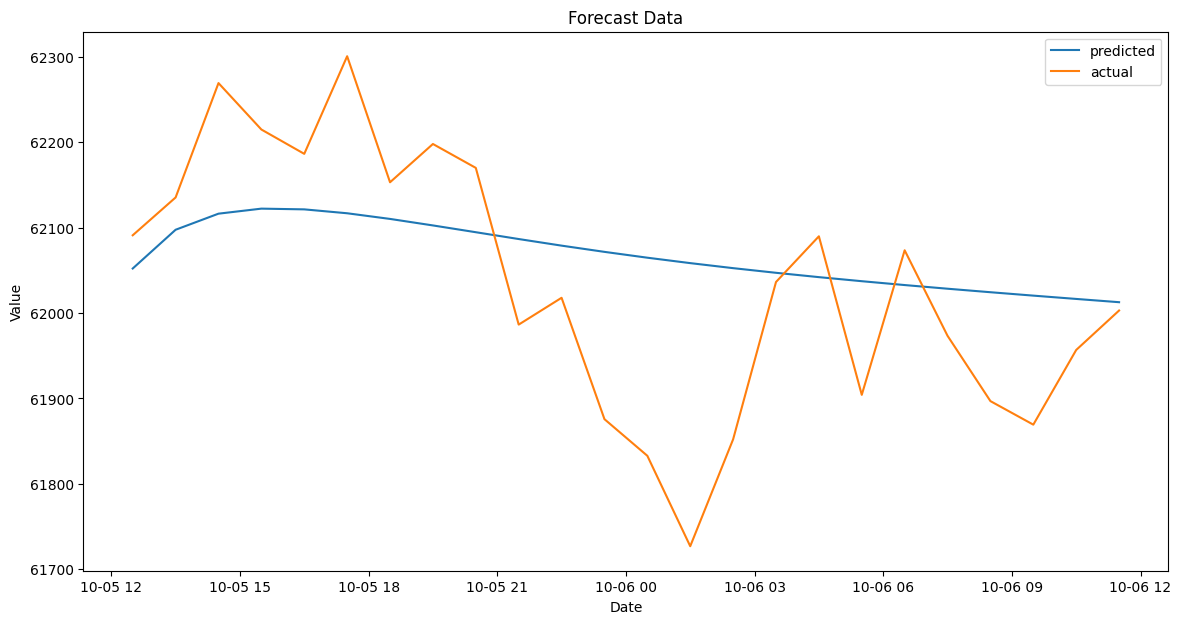

In [192]:
plt.figure(figsize=(14, 7))
# fc_df.plot()
for column in fc_df.columns:
    plt.plot(fc_df.index, fc_df[column], label=column)
plt.title('Forecast Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

**The minimal deviation between the actual and predicted prices suggests that the model is effective in forecasting short-term price movements.**

In [175]:
predicted_dates = pd.date_range(start=df1.index[-1] + pd.Timedelta(hours=1), periods=24, freq='h')
predicted_df = pd.DataFrame({'Predicted': predicted_prices}, index=predicted_dates)

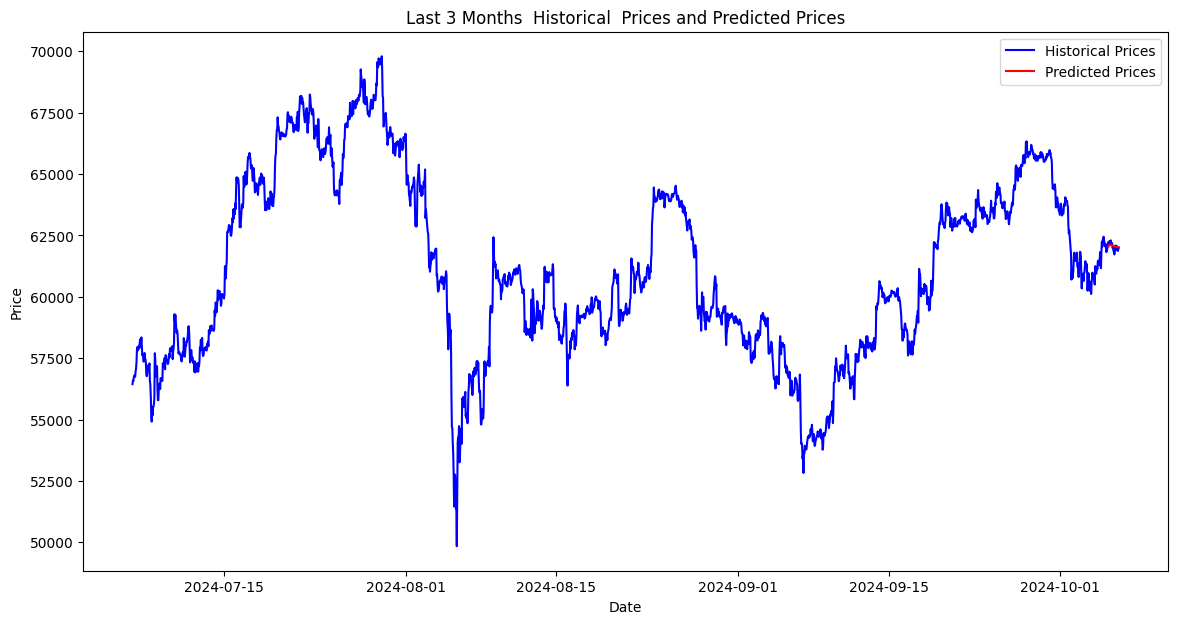

In [200]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df.Close, label='Historical Prices', color='blue')
plt.plot(predicted_df.index, predicted_df['Predicted'], label='Predicted Prices', color='red')
plt.title('Last 3 Months  Historical  Prices and Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

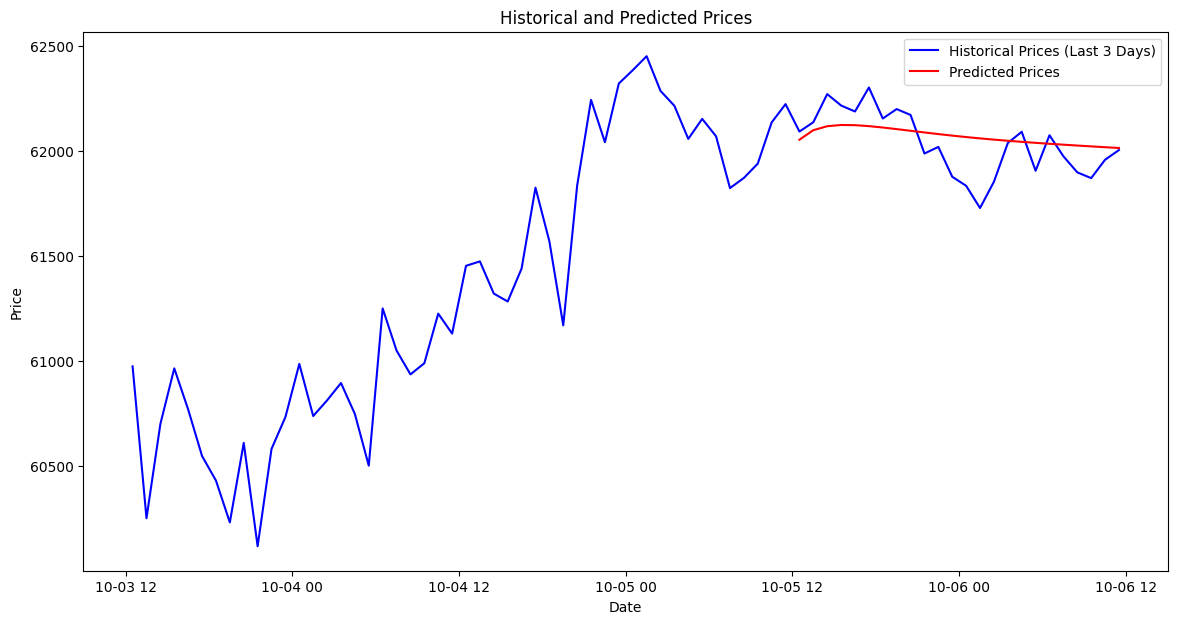

In [195]:
plt.figure(figsize=(14, 7))
plt.plot(df.tail(72).index, df.tail(72).Close, label='Historical Prices (Last 3 Days)', color='blue')
plt.plot(predicted_df.index, predicted_df['Predicted'], label='Predicted Prices', color='red')
plt.title('Historical and Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [199]:
historical_trace = go.Scatter(x=df.tail(100).index,y=df.tail(100)['Close'],mode='lines',name='Historical Prices',line=dict(color='blue'))
predicted_trace = go.Scatter(x=predicted_df.index,y=predicted_df['Predicted'],mode='lines',name='Predicted Prices',line=dict(color='red'))
layout = go.Layout(title='Historical and Predicted Prices',xaxis=dict(title='Date'),yaxis=dict(title='Price'),legend=dict(x=0, y=1))
go.Figure(data=[historical_trace, predicted_trace], layout=layout)

**After training an LSTM  (Long Short-Term Memory) model on the hourly data from the past three months, excluding the last 24 hours, we observed that the model's predictions for the next 24 hours align closely with the actual values. The visual analysis of the plots indicates a strong correlation between the predicted and actual prices, highlighting the model's effectiveness in capturing market trends.**